In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline

In [2]:
data = pd.read_csv('./data/Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
address2country = pd.read_csv('./data/IpAddress_to_Country.csv')
address2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [4]:
# Merge the data based on IP address matching
def get_country(ip):
    matching_rows = address2country[(ip >= address2country['lower_bound_ip_address']) & 
                                    (ip <= address2country['upper_bound_ip_address'])]
    if not matching_rows.empty:
        return matching_rows.iloc[0]['country']
    return 'NA'  # Return 'NA' if no match is found

# Apply the function to get country information based on IP address
data['country'] = data['ip_address'].apply(get_country)

# Print the first 5 rows of the merged data
print(data.head())


   user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class        country  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0          Japan  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  United States  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  United States  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0             NA  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  United States  


In [5]:
# Get the time difference between purchase time and signup time
data['time_diff'] = (data['purchase_time'] - data['signup_time']).dt.total_seconds()

# Check user number for unique devices (how many different users are associated with each device)
data['device_num'] = data.groupby('device_id')['user_id'].transform('nunique')

# Check user number for unique ip_address (how many different users are associated with each IP address)
data['ip_num'] = data.groupby('ip_address')['user_id'].transform('nunique')

# Signup day and week (extract day of the week and week of the year)
data['signup_day'] = data['signup_time'].dt.dayofweek
data['signup_week'] = data['signup_time'].dt.isocalendar().week

# Purchase day and week (extract day of the week and week of the year)
data['purchase_day'] = data['purchase_time'].dt.dayofweek
data['purchase_week'] = data['purchase_time'].dt.isocalendar().week

# Display the first 5 rows of the updated dataframe
print(data.head())


   user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class        country  \
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0          Japan   
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  United States   
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  United States   
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0             NA   
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  United States   

   time_diff  device_num  ip_num  signup_day  signup_week  purchase_day  \
0  4506682.0           

In [6]:
data = pd.get_dummies(data, columns=['source', 'browser', 'sex', 'country'], drop_first=True)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Prepare the features and target
X = data.drop(['user_id', 'signup_time', 'purchase_time', 'class', 'device_id', 'ip_address'], axis=1)
y = data['class']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41117
           1       1.00      0.54      0.70      4217

    accuracy                           0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



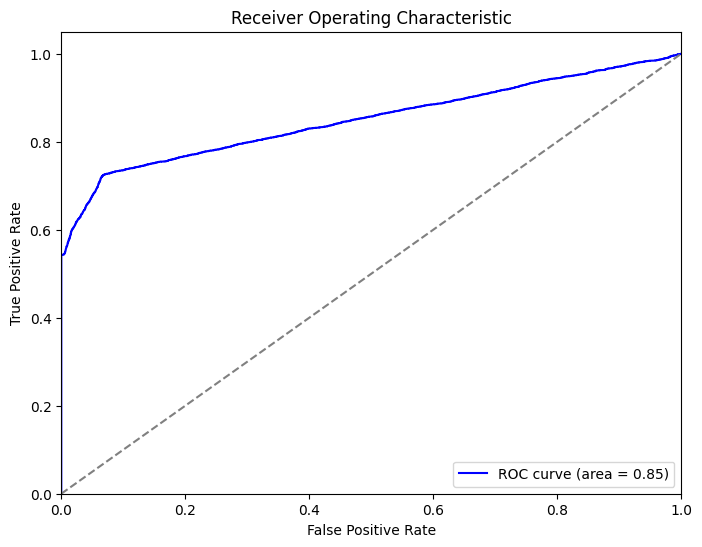

In [8]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()